## Notebook for experimenting with MV benchmarks

In [ ]:
### Import relevant libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import font_manager
import os
from tqdm import tqdm
import json
import pickle
from scipy.io import loadmat
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from helper_functions.AD_funcs import embed_wrapper
from helper_functions.clustering_funcs import align_clusters

sim_params = {
        'dataset': 'Yale',
        'delete_kernels': False,
        'generate_data': True,
        'animate' : True,  #  animation generation increases the run time
        'evd_solver': 'arpack',  # 'arpack' / 'randomized' / 'svd'
        'ad_methods': ['ad', 'adm_plus'],
        'embed_dim': 30,
        'clusters': 15,
        't': 0.2,
        'scale': 0.1,
        'sigma_mode' : 'median',  # 'median' , 'scale'
        'missing_ratio': 0.5,  # ratio of samples missing from second view
        'cmap': 'custom',
        'reps': 10
    }

np.random.seed(42)

data_path = os.path.join("mv_datasets", f"{sim_params['dataset']}.mat")
# fig_str = os.path.join("figures", f"{sim_params['dataset']}")
# figures_path = f"{fig_str}_{sim_params['N']}_lag_{sim_params['lag']}_{sim_params['views']}_tlen_{sim_params['traj_len']}_scale_{sim_params['scale']}_final_run".replace('.', 'p')
# os.makedirs(figures_path, exist_ok=True)
# Nr = sim_params['Nr'] # number of samples in the reference set
# N_d = sim_params['N']

# with open(f"{figures_path}/sim_params.json", 'w') as fp:
#     json.dump(sim_params, fp, indent=4)

In [8]:
# Load the mat file
print(f"Loading data from: {data_path}")
data = loadmat(data_path)

# Extract views and labels
X = data['X']  # Cell array containing multiple views
y_true = data['y'].flatten()  # Ground truth labels

# Extract individual views from the cell array
view1 = X[0, 0]  # First view
view2 = X[1, 0]  # Second view

n_samples = view1.shape[0]
n_clusters = y_true.max()
missing_ratio = sim_params['missing_ratio']

# Calculate reference set size (samples with both views)
n_ref = int(n_samples * (1 - missing_ratio))

## sample reference set
ref_indices = np.random.choice(n_samples, n_ref, replace=False)
s1_ref = view1[ref_indices, :]
# organize the full set to match the reference set order
aligned_indices = np.concatenate((ref_indices, np.setdiff1d(np.arange(n_samples), ref_indices)))
s1_full = view1[aligned_indices, :]
s2_ref = view2[ref_indices, :]
s2_full = view2[aligned_indices, :]

# rearrange labels to match the new order of samples
y_true_aligned = y_true[aligned_indices]

print(f"\nDataset: {sim_params['dataset']}")
print(f"Total samples: {n_samples}")
print(f"Number of clusters: {n_clusters}")
print(f"Missing ratio: {missing_ratio}")
print(f"Reference set size (both views): {n_ref}")
print(f"Missing samples (view 1 only): {n_samples - n_ref}")
print(f"View 1 shape: {view1.shape}")
print(f"View 2 shape: {view2.shape}")
print(f"Labels shape: {y_true.shape}")
print(f"Unique labels: {np.unique(y_true)}")

Loading data from: mv_datasets\Yale.mat

Dataset: Yale
Total samples: 165
Number of clusters: 15
Missing ratio: 0.5
Reference set size (both views): 82
Missing samples (view 1 only): 83
View 1 shape: (165, 4096)
View 2 shape: (165, 3304)
Labels shape: (165,)
Unique labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [9]:
def calculate_purity(y_true, y_pred):
    """
    Calculate clustering purity.
    
    Parameters:
    - y_true: true labels
    - y_pred: predicted cluster labels
    
    Returns:
    - purity score
    """
    from scipy.optimize import linear_sum_assignment
    from sklearn.metrics import confusion_matrix
    
    # Create confusion matrix
    contingency_matrix = confusion_matrix(y_true, y_pred)
    
    # Find optimal assignment
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    
    # Calculate purity
    purity = contingency_matrix[row_ind, col_ind].sum() / len(y_true)
    
    return purity


def evaluate_clustering(embedding, y_true, n_clusters, method_name):
    """
    Perform clustering on embedding and evaluate with multiple metrics.
    
    Parameters:
    - embedding: the embedding vectors
    - y_true: ground truth labels
    - n_clusters: number of clusters
    - method_name: name of the method for display
    
    Returns:
    - Dictionary with accuracy, NMI, and purity
    """
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(embedding)
    
    # Align clusters using Hungarian algorithm
    y_pred_aligned = align_clusters(y_true, y_pred)
    
    # Calculate metrics
    accuracy = np.mean(y_pred_aligned == y_true)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    purity = calculate_purity(y_true, y_pred)
    
    print(f"\n{method_name} Results:")
    print(f"  Clustering Accuracy: {accuracy:.4f}")
    print(f"  NMI: {nmi:.4f}")
    print(f"  Purity: {purity:.4f}")
    
    return {
        'method': method_name,
        'accuracy': accuracy,
        'nmi': nmi,
        'purity': purity
    }

In [ ]:
from helper_functions.AD_funcs import Create_Transition_Mat, Create_Asym_Tran_Kernel

# Hyperparameter tuning on scale parameter
scale_grid = [0.1, 0.3, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30]

print(f"\n{'='*80}")
print("HYPERPARAMETER TUNING: Scale Parameter Grid Search")
print(f"{'='*80}")
print(f"Scale values to test: {scale_grid}")
print(f"Methods: {sim_params['ad_methods']}")
print(f"{'='*80}\n")

# Store all results
all_results = []

for scale in tqdm(scale_grid, desc="Scale values"):
    print(f"\n{'='*60}")
    print(f"Testing Scale = {scale}")
    print(f"{'='*60}")
    
    for method in sim_params['ad_methods']:
        print(f"\n  Method: {method.upper()}")
        
        try:
            # Generate embedding using embed_wrapper with current scale
            if method == 'ad':
                K1, _ = Create_Transition_Mat(s1_full, scale=scale, mode=sim_params['sigma_mode'])
                K2, _ = Create_Transition_Mat(s2_full, scale=scale, mode=sim_params['sigma_mode'])
                embedding = embed_wrapper(
                    s1_full=s1_full,
                    s2_full=s2_full,
                    method=method,
                    embed_dim=sim_params['embed_dim'],
                    t=sim_params['t'],
                    K1=K1,
                    K2=K2,
                    solver=sim_params['evd_solver']
                )
            else:
                # For adm_plus, create asymmetric and symmetric kernels
                A1, _, _ = Create_Asym_Tran_Kernel(s1_full, s1_ref, scale=scale, mode=sim_params['sigma_mode'])
                K2, _ = Create_Transition_Mat(s2_ref, scale=scale, mode=sim_params['sigma_mode'])
                embedding = embed_wrapper(
                    s1_ref=s1_ref,
                    s1_full=s1_full,
                    s2_ref=s2_ref,
                    method=method,
                    embed_dim=sim_params['embed_dim'],
                    t=sim_params['t'],
                    K1=A1,
                    K2=K2,
                    solver=sim_params['evd_solver']
                )
            
            # Perform KMeans clustering
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            y_pred = kmeans.fit_predict(embedding)
            
            # Align clusters using Hungarian algorithm
            y_pred_aligned = align_clusters(y_true_aligned, y_pred)
            
            # Calculate metrics
            accuracy = np.mean(y_pred_aligned == y_true_aligned)
            nmi = normalized_mutual_info_score(y_true_aligned, y_pred)
            purity = calculate_purity(y_true_aligned, y_pred)
            ari = adjusted_rand_score(y_true_aligned, y_pred)
            
            print(f"    Accuracy: {accuracy:.4f}, NMI: {nmi:.4f}, Purity: {purity:.4f}")
            
            all_results.append({
                'scale': scale,
                'method': method,
                'accuracy': accuracy,
                'nmi': nmi,
                'purity': purity,
                'ari': ari
            })
            
        except Exception as e:
            print(f"   Error at scale {scale}: {str(e)}")
            all_results.append({
                'scale': scale,
                'method': method,
                'accuracy': np.nan,
                'nmi': np.nan,
                'purity': np.nan
            })

# Create results DataFrame
results_grid_df = pd.DataFrame(all_results)

# Print summary
print(f"\n{'='*80}")
print("GRID SEARCH RESULTS SUMMARY")
print(f"{'='*80}\n")
print(results_grid_df.to_string(index=False))

# Find best parameters for each method
print(f"\n{'='*80}")
print("BEST PARAMETERS BY METHOD")
print(f"{'='*80}\n")

for method in sim_params['ad_methods']:
    method_results = results_grid_df[results_grid_df['method'] == method]
    
    # Best by accuracy
    best_acc = method_results.loc[method_results['accuracy'].idxmax()]
    print(f"{method.upper()}:")
    print(f"  Best Accuracy: {best_acc['accuracy']:.4f} at scale={best_acc['scale']}")
    print(f"  Best NMI: {method_results.loc[method_results['nmi'].idxmax(), 'nmi']:.4f} at scale={method_results.loc[method_results['nmi'].idxmax(), 'scale']}")
    print(f"  Best Purity: {method_results.loc[method_results['purity'].idxmax(), 'purity']:.4f} at scale={method_results.loc[method_results['purity'].idxmax(), 'scale']}")
    print()


HYPERPARAMETER TUNING: Scale Parameter Grid Search
Scale values to test: [0.1, 0.3, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30]
Methods: ['ad', 'adm_plus']



Scale values:   0%|          | 0/12 [00:00<?, ?it/s]c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Scale values:   8%|▊         | 1/12 [00:00<00:01,  6.37it/s]c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the 


Testing Scale = 0.1

  Method: AD
 Kernel computation finished, in 0.023441314697265625 seconds
 Kernel computation finished, in 0.015955448150634766 seconds
    Accuracy: 0.1212, NMI: 0.1486, Purity: 0.1212

  Method: ADM_PLUS
 Kernel computation finished, in 0.020968914031982422 seconds
 Kernel computation finished, in 0.003989219665527344 seconds
    Accuracy: 0.1030, NMI: 0.1470, Purity: 0.1030

Testing Scale = 0.3

  Method: AD
 Kernel computation finished, in 0.02094268798828125 seconds
 Kernel computation finished, in 0.015956640243530273 seconds


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Scale values:  17%|█▋        | 2/12 [00:00<00:01,  6.51it/s]c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.w

    Accuracy: 0.1758, NMI: 0.2538, Purity: 0.1758

  Method: ADM_PLUS
 Kernel computation finished, in 0.019945859909057617 seconds
 Kernel computation finished, in 0.003988981246948242 seconds
    Accuracy: 0.2848, NMI: 0.3987, Purity: 0.2848

Testing Scale = 0.5

  Method: AD
 Kernel computation finished, in 0.02245020866394043 seconds
 Kernel computation finished, in 0.014961004257202148 seconds
    Accuracy: 0.2848, NMI: 0.3780, Purity: 0.2848

  Method: ADM_PLUS
 Kernel computation finished, in 0.019946813583374023 seconds
 Kernel computation finished, in 0.004496335983276367 seconds


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Scale values:  25%|██▌       | 3/12 [00:00<00:01,  6.68it/s]c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.w

    Accuracy: 0.4424, NMI: 0.5275, Purity: 0.4424

Testing Scale = 1

  Method: AD
 Kernel computation finished, in 0.020943641662597656 seconds
 Kernel computation finished, in 0.016953706741333008 seconds
    Accuracy: 0.4061, NMI: 0.5314, Purity: 0.4061

  Method: ADM_PLUS
 Kernel computation finished, in 0.02094292640686035 seconds
 Kernel computation finished, in 0.003989219665527344 seconds
    Accuracy: 0.5152, NMI: 0.5743, Purity: 0.5152

Testing Scale = 2

  Method: AD
 Kernel computation finished, in 0.0219571590423584 seconds
 Kernel computation finished, in 0.014959335327148438 seconds


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Scale values:  42%|████▏     | 5/12 [00:00<00:01,  6.90it/s]c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.w

    Accuracy: 0.5152, NMI: 0.6009, Purity: 0.5152

  Method: ADM_PLUS
 Kernel computation finished, in 0.020943403244018555 seconds
 Kernel computation finished, in 0.003990650177001953 seconds
    Accuracy: 0.5030, NMI: 0.5486, Purity: 0.5030

Testing Scale = 3

  Method: AD
 Kernel computation finished, in 0.02194046974182129 seconds
 Kernel computation finished, in 0.014958858489990234 seconds
    Accuracy: 0.4848, NMI: 0.5508, Purity: 0.4848

  Method: ADM_PLUS
 Kernel computation finished, in 0.019945621490478516 seconds
 Kernel computation finished, in 0.0039904117584228516 seconds
    Accuracy: 0.5697, NMI: 0.5904, Purity: 0.5697


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Scale values:  58%|█████▊    | 7/12 [00:01<00:00,  7.00


Testing Scale = 5

  Method: AD
 Kernel computation finished, in 0.021943330764770508 seconds
 Kernel computation finished, in 0.014467477798461914 seconds
    Accuracy: 0.5455, NMI: 0.5957, Purity: 0.5455

  Method: ADM_PLUS
 Kernel computation finished, in 0.02094268798828125 seconds
 Kernel computation finished, in 0.0039899349212646484 seconds
    Accuracy: 0.4788, NMI: 0.5594, Purity: 0.4788

Testing Scale = 7

  Method: AD
 Kernel computation finished, in 0.021939754486083984 seconds
 Kernel computation finished, in 0.015956640243530273 seconds


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Scale values:  67%|██████▋   | 8/12 [00:01<00:00,  7.05it/s]c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.w

    Accuracy: 0.4909, NMI: 0.5765, Purity: 0.4909

  Method: ADM_PLUS
 Kernel computation finished, in 0.02097153663635254 seconds
 Kernel computation finished, in 0.002991914749145508 seconds
    Accuracy: 0.5333, NMI: 0.6212, Purity: 0.5333

Testing Scale = 10

  Method: AD
 Kernel computation finished, in 0.02094411849975586 seconds
 Kernel computation finished, in 0.015955209732055664 seconds
    Accuracy: 0.5697, NMI: 0.6367, Purity: 0.5697

  Method: ADM_PLUS
 Kernel computation finished, in 0.020943403244018555 seconds
 Kernel computation finished, in 0.003988981246948242 seconds


Scale values:  75%|███████▌  | 9/12 [00:01<00:00,  7.06it/s]c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.w

    Accuracy: 0.5697, NMI: 0.6035, Purity: 0.5697

Testing Scale = 15

  Method: AD
 Kernel computation finished, in 0.025447607040405273 seconds
 Kernel computation finished, in 0.0404055118560791 seconds
    Accuracy: 0.5091, NMI: 0.5774, Purity: 0.5091

  Method: ADM_PLUS
 Kernel computation finished, in 0.01994490623474121 seconds
 Kernel computation finished, in 0.003989219665527344 seconds
    Accuracy: 0.5091, NMI: 0.5606, Purity: 0.5091


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Scale values:  92%|█████████▏| 11/12 [00:01<00:00,  6.68it/s]


Testing Scale = 20

  Method: AD
 Kernel computation finished, in 0.022940874099731445 seconds
 Kernel computation finished, in 0.01546621322631836 seconds
    Accuracy: 0.5333, NMI: 0.5809, Purity: 0.5333

  Method: ADM_PLUS
 Kernel computation finished, in 0.01994609832763672 seconds
 Kernel computation finished, in 0.003989219665527344 seconds
    Accuracy: 0.4970, NMI: 0.5690, Purity: 0.4970

Testing Scale = 30

  Method: AD
 Kernel computation finished, in 0.020942211151123047 seconds
 Kernel computation finished, in 0.01595616340637207 seconds


c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\barweiss\anaconda3\envs\geometric_learning\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Scale values: 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]

    Accuracy: 0.5636, NMI: 0.6085, Purity: 0.5636

  Method: ADM_PLUS
 Kernel computation finished, in 0.0204622745513916 seconds
 Kernel computation finished, in 0.003989219665527344 seconds
    Accuracy: 0.5576, NMI: 0.5749, Purity: 0.5576

GRID SEARCH RESULTS SUMMARY

 scale   method  accuracy      nmi   purity
   0.1       ad  0.121212 0.148591 0.121212
   0.1 adm_plus  0.103030 0.147050 0.103030
   0.3       ad  0.175758 0.253801 0.175758
   0.3 adm_plus  0.284848 0.398672 0.284848
   0.5       ad  0.284848 0.377953 0.284848
   0.5 adm_plus  0.442424 0.527470 0.442424
   1.0       ad  0.406061 0.531390 0.406061
   1.0 adm_plus  0.515152 0.574255 0.515152
   2.0       ad  0.515152 0.600938 0.515152
   2.0 adm_plus  0.503030 0.548601 0.503030
   3.0       ad  0.484848 0.550844 0.484848
   3.0 adm_plus  0.569697 0.590382 0.569697
   5.0       ad  0.545455 0.595717 0.545455
   5.0 adm_plus  0.478788 0.559358 0.478788
   7.0       ad  0.490909 0.576534 0.490909
   7.0 adm_plus  0.53333

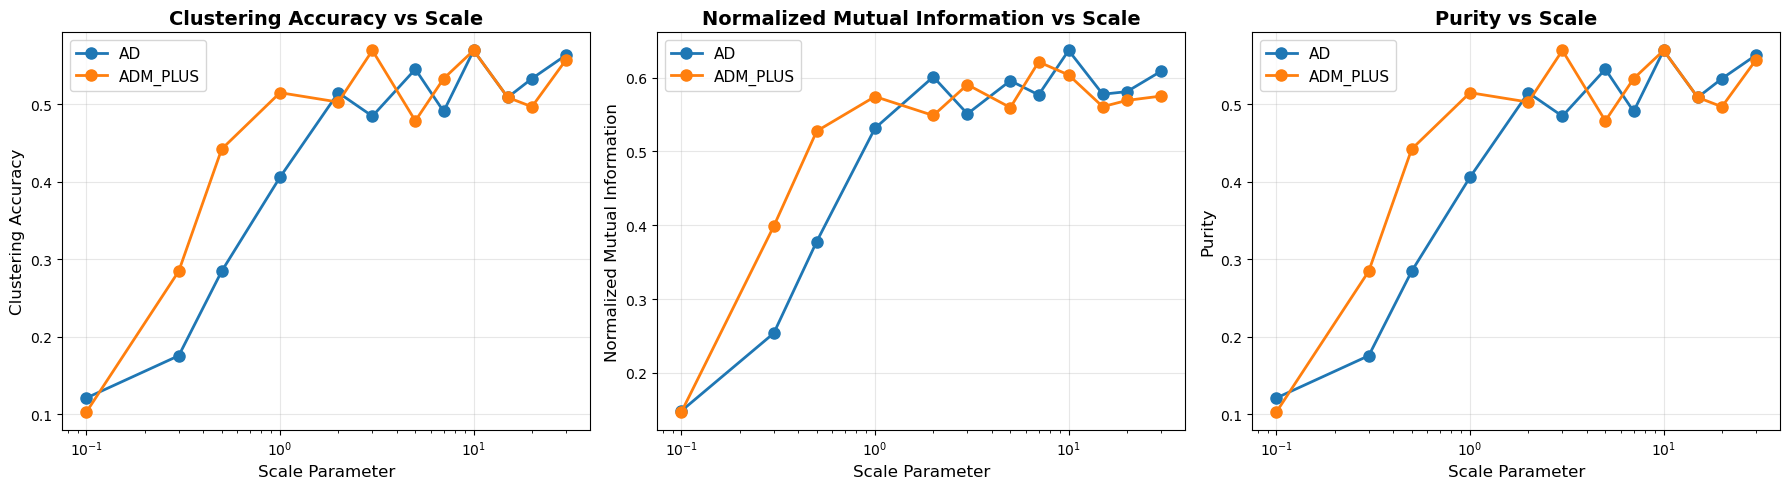


Dataset: Yale
Missing ratio: 0.5
Embedding dimension: 30
Diffusion time: 0.2


In [17]:
# Visualize grid search results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['accuracy', 'nmi', 'purity']
titles = ['Clustering Accuracy', 'Normalized Mutual Information', 'Purity']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]
    
    for method in sim_params['ad_methods']:
        method_data = results_grid_df[results_grid_df['method'] == method]
        ax.plot(method_data['scale'], method_data[metric], marker='o', label=method.upper(), linewidth=2, markersize=8)
    
    ax.set_xlabel('Scale Parameter', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} vs Scale', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')

plt.tight_layout()
plt.show()

print(f"\nDataset: {sim_params['dataset']}")
print(f"Missing ratio: {sim_params['missing_ratio']}")
print(f"Embedding dimension: {sim_params['embed_dim']}")
print(f"Diffusion time: {sim_params['t']}")